In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.datasets import load_iris

import mygrad.components as mc
import mygrad.functional as mf
import mygrad.utils as mgutils
from mygrad.losses import MeanSquareErrorLoss, CategorialCorssEntropy, Loss
from mygrad.optimizers import RMSProp, Adam
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import Trainer as RegressionTrainer, CategoricalClassificationTrainer, ProgressBar
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

# Define the AE for the model

In [53]:
class Mutation:
    @staticmethod
    def gaussian(X: np.ndarray, sigma: float = 0.1, p: float = 0.2) -> np.ndarray:
        """
        Apply gaussian mutation to the input matrix X with a given probability p
        """
        mask = (np.random.random(X.shape) < p) * 1
        noise = np.random.normal(0, sigma, X.shape)
        return X + mask * noise


class Crossover:
    @staticmethod
    def get_parents(population: np.ndarray, crossover_p: float = 0.7) -> tuple[np.ndarray, np.ndarray]:
        """
        Split the population into two groups of parents
        """
        prob_vector = np.random.random(population.shape[0])
        reproductive_population = population[prob_vector < crossover_p]
        idx = np.arange(reproductive_population.shape[0])
        np.random.shuffle(idx)
        reproductive_population = reproductive_population[idx]

        split_idx = reproductive_population.shape[0] // 2

        return reproductive_population[:split_idx], reproductive_population[split_idx:(2*split_idx)]

    @staticmethod
    def pointwise(parents1: np.ndarray, parents2: np.ndarray, split_portion: float = 0.5) -> np.ndarray:
        """
        Apply pointwise crossover to the input matrices parent1 and parent2 with a given probability p
        """
        assert parents1.shape == parents2.shape
        split_point = int(parents1.shape[1] * split_portion)
        return np.concatenate([parents1[:, :split_point], parents2[:, split_point:]], axis=1)

    @staticmethod
    def mean(parents1: np.ndarray, parents2: np.ndarray) -> np.ndarray:
        """
        Apply mean crossover to the input matrices parent1 and parent2 with a given probability p
        """
        assert parents1.shape == parents2.shape
        return (parents1 + parents2) / 2


def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input matrix X
    """
    return (X - np.min(X)) / (np.max(X) - np.min(X))


class Selection:
    @staticmethod
    def roulette(population: np.ndarray, fitness: np.ndarray, n: int = 1) -> np.ndarray:
        """
        Apply roulette selection to the input population. Select n individuals based on their fitness
        """
        total_fitness = np.sum(fitness)
        probabilities = fitness / total_fitness
        idx = np.random.choice(population.shape[0], n, p=probabilities)
        return population[idx]

    @staticmethod
    def elitist(population: np.ndarray, fitness: np.ndarray, n: int = 1, elite_percentage: float = 0.15) -> np.ndarray:
        """
        Apply elitist selection to the input population. Select the n fittest individuals
        """
        fitness = normalize(fitness)
        m = int(population.shape[0] * elite_percentage)
        sorted_population = population[np.argsort(fitness)[::-1]]

        elite_population = sorted_population[:m]
        left_over_population = sorted_population[m:]
        left_over_fitness = fitness[np.argsort(fitness)[::-1]][m:]

        rest = []
        while (len(elite_population) + len(rest)) < n:
            probs = left_over_fitness / left_over_fitness.sum()
            idx = np.random.choice(len(left_over_population), p=probs)
            left_over_fitness[idx] = 0 # This individual will never be picked again
            rest.append(left_over_population[idx])

        return np.concatenate((elite_population, np.array(rest)))


    @staticmethod
    def fittest(population: np.ndarray, fitness: np.ndarray, n: int = 1) -> np.ndarray:
        """
        Apply fittest selection to the input population. Select the n fittest individuals
        """
        idx = np.argsort(fitness)[::-1][:n]
        return population[idx]

In [54]:
def eval_population(model_skeleton: mc.Sequential, loss: Loss, population: np.ndarray, X_train: np.ndarray, y_train: np.ndarray):
    scores = []
    for i in range(population.shape[0]):
        param_vector = population[i]
        mgutils.set_parameter_vector(model_skeleton, param_vector)
        y_pred = model_skeleton.forward(X_train)
        scores.append(-float(loss.value(y_pred, y_train)))
    return np.array(scores)

In [55]:
def train_ae(model_skeleton: mc.Component, loss: Loss, X_train, y_train, population_size=100, epochs=100):
    initial_vector = mgutils.get_param_vector(model_skeleton)
    population = np.random.random((population_size, initial_vector.shape[0]))

    scores = []
    # Run the genetic algorithm
    pbar = tqdm(range(epochs))
    for t in pbar:
        parents1, parents2 = Crossover.get_parents(population, 0.9)
        children = Crossover.mean(parents1, parents2)
        children = Mutation.gaussian(children, 0.3, 0.3)

        population = np.concatenate([population, children])
        fitness = eval_population(model_skeleton, loss, population, X_train, y_train)
        best_score = np.max(fitness)
        scores.append(best_score)
        population = Selection.elitist(population, fitness, n = population_size, elite_percentage=0.3)

        pbar.set_postfix({"best_score": best_score})
    return np.array(scores)

## Mutlimodal large

In [56]:
train_df = pd.read_csv("../mio1/regression/multimodal-large-training.csv")
test_df = pd.read_csv("../mio1/regression/multimodal-large-test.csv")
X_train = train_df["x"].values
y_train = train_df["y"].values
p = np.argsort(X_train)

input_normalizer = StandardScaler()
output_normalizer = StandardScaler()

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_train = input_normalizer.fit_transform(X_train)
y_train = output_normalizer.fit_transform(y_train)

Text(0.5, 1.0, 'Znormalizowany zbiór treningowy multimodal large')

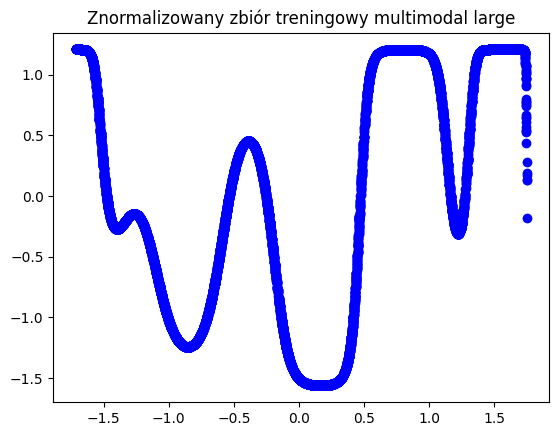

In [57]:
plt.plot(X_train[p, :], y_train[p, :], "bo")
plt.title("Znormalizowany zbiór treningowy multimodal large")

## Train with Backprop

In [58]:
model = mc.Sequential(
    mc.Linear(1, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
)

In [59]:
optimizer = RMSProp(model.parameters(), learning_rate=1e-4)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train, y_train, batch_size=20, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses_rms = trainer.train(100)["loss"]

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Funckja straty dla multimodal large \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane MSE: 0.0330')

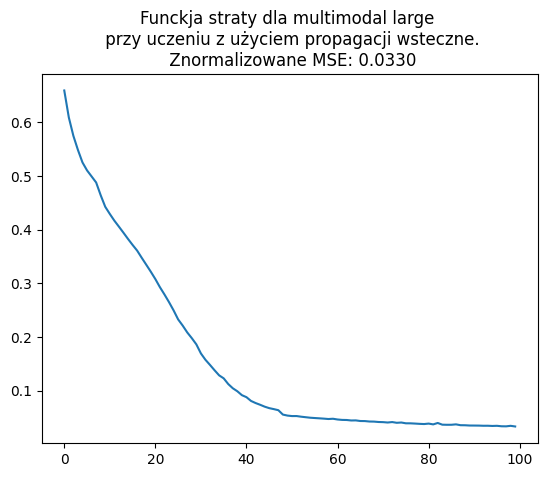

In [60]:
plt.plot(train_losses_rms)
plt.title(f"Funckja straty dla multimodal large \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane MSE: {train_losses_rms[-1]:.4f}")

## Train with AE

In [61]:
model_skeleton_multimodal = mc.Sequential(
    mc.Linear(1, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
)
model_skeleton_multimodal.eval()

In [62]:
scores = train_ae(model_skeleton_multimodal, loss, X_train, y_train, population_size=100, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_31988/4287386848.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores.append(-float(loss.value(y_pred, y_train)))


Text(0.5, 1.0, 'Funckja straty dla multimodal large \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: 0.7974')

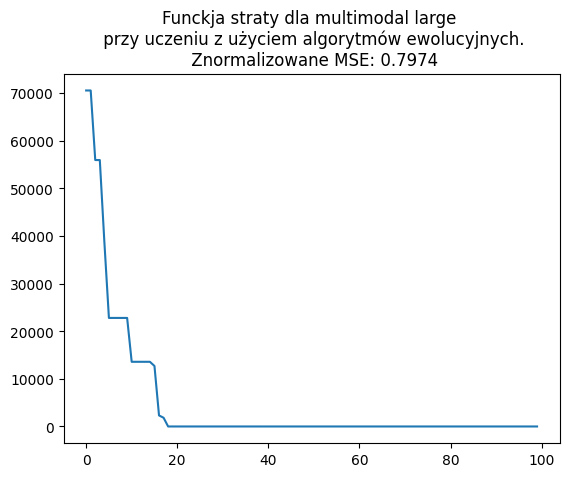

In [66]:
plt.plot(-scores)
plt.title(f"Funckja straty dla multimodal large \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: {-scores[-1]:.4f}")

Text(0.5, 1.0, 'Funckja straty dla multimodal large')

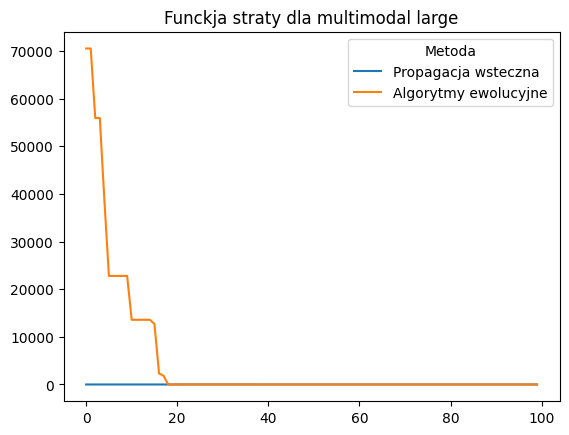

In [68]:
plt.plot(train_losses_rms, label="Propagacja wsteczna")
plt.plot(-scores, label="Algorytmy ewolucyjne")
plt.legend(title="Metoda")
plt.title(f"Funckja straty dla multimodal large")

# Iris dataset

In [5]:
load_iris(as_frame=True)["data"]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [6]:
iris = load_iris(as_frame=True)
X_train = iris["data"].values
y_train = iris["target"].values

input_normalizer = StandardScaler()
output_normalizer = StandardScaler()

y_train = y_train.reshape(-1, 1)
y_train = mf.onehot_encode(y_train, 3)

## Train with Backprop

In [7]:
model = mc.Sequential(
    mc.Linear(4, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 3, init="uniform"),
    mc.Softmax(),
)

In [8]:
optimizer = RMSProp(model.parameters(), learning_rate=1e-4)
loss = CategorialCorssEntropy()
train_dataloader = NumpyClassificationDataloader(X_train, y_train, batch_size=20, shuffle=True, is_one_hot=True)
trainer = CategoricalClassificationTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses_rms = trainer.train(200)["loss"]

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:47: RuntimeWarning: invalid value encountered in divide
  recall = tp / np.sum(y_true, axis=0)
/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:48: RuntimeWarning: invalid value encountered in divide
  fscores = 2 * precision * recall / (precision + recall)


Text(0.5, 1.0, 'Funckja straty dla Iris \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane CE: 0.1390')

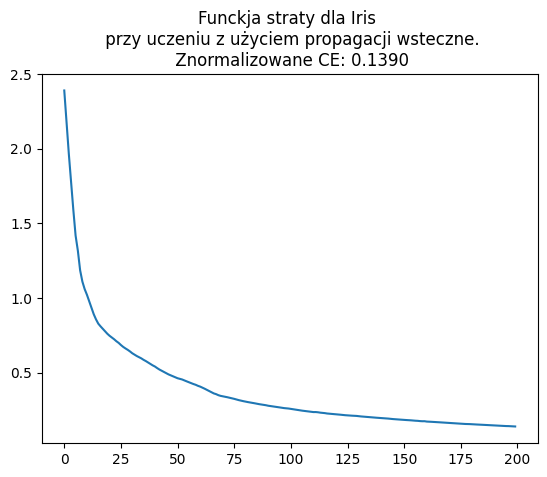

In [9]:
plt.plot(train_losses_rms)
plt.title(f"Funckja straty dla Iris \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane CE: {train_losses_rms[-1]:.4f}")

## Train with AE

In [10]:
iris_model = mc.Sequential(
    mc.Linear(4, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 3, init="uniform"),
    mc.Softmax(version="stable"),
)
iris_model.eval()

In [11]:
scores = train_ae(iris_model, loss, X_train, y_train, population_size=100, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_31988/1268712326.py:79: RuntimeWarning: invalid value encountered in divide
  probs = left_over_fitness / left_over_fitness.sum()


ValueError: probabilities contain NaN

Text(0.5, 1.0, 'Funckja straty dla multimodal large \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: 0.9913')

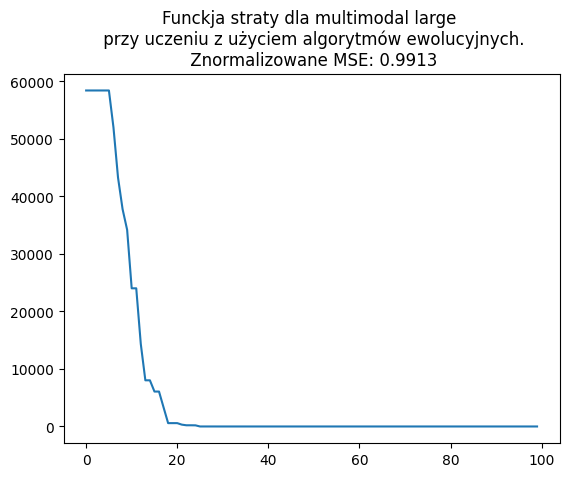

In [113]:
plt.plot(-scores)
plt.title(f"Funckja straty dla multimodal large \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: {-scores[-1]:.4f}")

## Auto MPG

In [69]:
from ucimlrepo import fetch_ucirepo 
  
auto_mpg = fetch_ucirepo(id=9) 
X_train = auto_mpg.data.features.values
y_train = auto_mpg.data.targets.values.reshape(-1, 1)

input_normalizer = StandardScaler()
output_normalizer = StandardScaler()

X_train = X_train[:, [0,1,3,4,5,6]]
y_train = y_train.reshape(-1, 1)

X_train = input_normalizer.fit_transform(X_train)
y_train = output_normalizer.fit_transform(y_train)

## Train with Backprop

In [70]:
model = mc.Sequential(
    mc.Linear(6, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
)

In [71]:
optimizer = RMSProp(model.parameters(), learning_rate=1e-4)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train, y_train, batch_size=20, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses_rms = trainer.train(100)["loss"]

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Funckja straty dla Auto MPG \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane MSE: 0.1652')

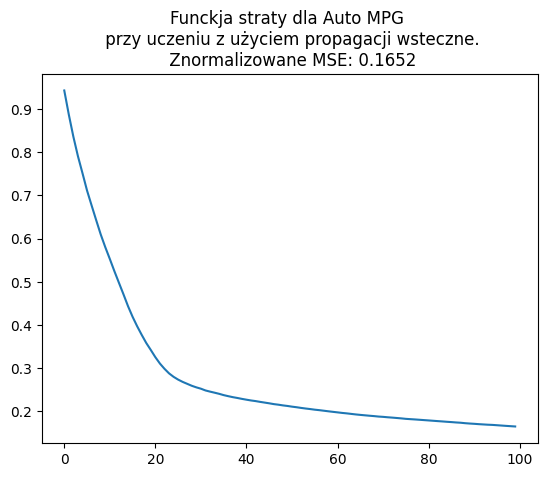

In [72]:
plt.plot(train_losses_rms)
plt.title(f"Funckja straty dla Auto MPG \n przy uczeniu z użyciem propagacji wsteczne.\n Znormalizowane MSE: {train_losses_rms[-1]:.4f}")

## Train with AE

In [73]:
auto_model = mc.Sequential(
    mc.Linear(6, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
)
auto_model.eval()

In [74]:
scores = train_ae(auto_model, loss, X_train, y_train, population_size=100, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_31988/4287386848.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores.append(-float(loss.value(y_pred, y_train)))


Text(0.5, 1.0, 'Funckja straty dla multimodal large \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: 0.7259')

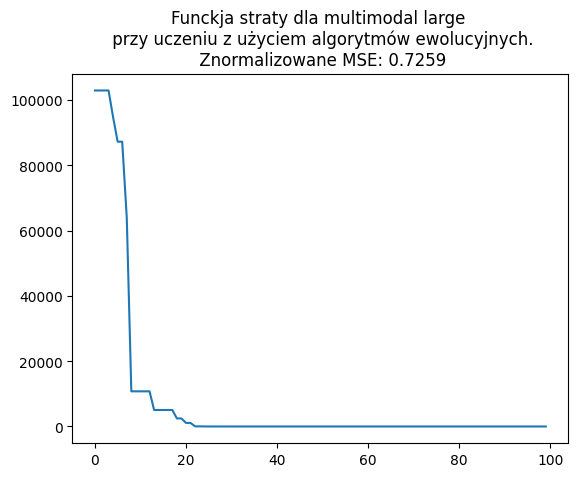

In [51]:
plt.plot(-scores)
plt.title(f"Funckja straty dla Auto-MPG \n przy uczeniu z użyciem algorytmów ewolucyjnych.\n Znormalizowane MSE: {-scores[-1]:.4f}")